# CRAN‑AI 

This work presents a **6G-oriented (edge-aware), AI-native cognitive relay framework** for power control that tightly couples physics-based modeling and system constraints with goal-driven, **unsupervised deep learning**. The proposed approach learns feasible power-allocation policies while protecting the primary user’s QoS, and extends the learning objective to a **multi-objective** formulation that balances secondary rate maximization with energy-efficiency improvement and outage reduction via a tunable smooth outage surrogate.

To enhance reliability, the framework incorporates **risk-aware training** to mitigate tail events and introduces a **hard safety layer** that deterministically enforces QoS constraints at inference time by rescaling network outputs. We further adopt a **budget-normalized action space** to improve numerical stability and generalization across operating conditions, and support **hybrid DF/CF operation** through separately trained DF and CF policies coupled with a scheme-selection mechanism (rule-based, with an optional learned selector). Finally, the framework enables **generalization** by conditioning policies on system parameters and improves **robustness** to imperfect CSI through imperfect-to-reference pairing (imperfect observations as inputs while evaluating physics on reference channels). A reproducible evaluation pipeline with brute-force baselines, standardized artifacts (CSV/JSON/plots), and deployment-oriented indicators (model size and inference latency) is provided to support edge-oriented validation.

**This notebook implements and evaluates the complete CRAN-AI pipeline (`cran_ai`):**

1. **Multi-objective unsupervised training** (Rate + QoS + EE + Outage proxy)  
2. **Risk-aware training** (CVaR / chance-style penalty)  
3. **Hard safety layer** (deterministic QoS satisfaction)  
4. **DF policy** and **CF policy** (AI-native normalized action space)  
5. **Hybrid DF/CF selection** (rule-based)  
6. **Brute-force baselines** (DF and CF)  
7. **Generalized policy** (system parameters appended to input)  
8. **Robust CSI pairing** (imperfect input, reference-physics loss)  
9. **Selector network** (supervised DF/CF classifier + threshold tuning)  
10. **Deployment indicators** (params, size, latency benchmark + export)

Run all cells top-to-bottom. Only edit the **Parameters** cell.

## Notation and Objectives

### Channel gains
Let the link gains be stacked as
$$
\mathbf{g}=\left[g_{SS}, g_{SR}, g_{RS}, g_{SP}, g_{RP}, g_{PP}, g_{PR}, g_{PS}\right].
$$

### AI‑native action space (normalized budgets)
$$
P_S=\gamma_S\,P_{S,\max},\quad P_R=\gamma_R\,P_{R,\max},\quad \gamma_S,\gamma_R\in[0,1],
$$
and DF includes \(\alpha\in[0,1]\).

### Primary QoS protection
Define an interference‑like metric \(Q(\cdot)\) and a QoS budget \(A(\cdot)\). The constraint is
$$
Q \le A.
$$
A **safety layer** rescales \((P_S,P_R)\) to guarantee feasibility.

### Energy efficiency
$$
EE=\frac{R_S}{P_S+P_R+P_c}.
$$

### Outage proxy
For target \(R_{S,\text{th}}\),
$$
\mathrm{OutageProxy}=\sigma\!\left(k\,(R_{S,\text{th}}-R_S)\right).
$$

### Multi‑objective loss (minimized)
$$
\mathcal{L}
= -w_r\,\mathbb{E}[R_S]
+ w_q\,\mathbb{E}\big[(Q-A)^+\big]
+ w_e\,\mathbb{E}\big[-EE\big]
+ w_o\,\mathbb{E}[\mathrm{OutageProxy}]
+ \mathcal{R}_{\text{risk}}.
$$


## Environment and Imports

The project must be run from the repository root (the folder that contains `cran/`, `configs/`, `experiments/`).


In [1]:
# Setup
import os
import sys
import json
import time
from pathlib import Path
from dataclasses import asdict

import numpy as np
import pandas as pd
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

PROJECT_ROOT = Path.cwd()
if not (PROJECT_ROOT / "cran").exists():
    raise RuntimeError(f"Run from project root. Current: {PROJECT_ROOT}")

print("Python:", sys.executable)
print("Torch :", torch.__version__)
print("CUDA  :", torch.cuda.is_available(), torch.cuda.get_device_name(0) if torch.cuda.is_available() else None)

# Project imports
from cran.utils.config_loader import merge_configs, save_config_snapshot
from cran.utils.seed import SeedConfig, set_global_seed, get_torch_device

from cran.reporting.artifact_registry import ArtifactPaths

from cran.policies.df_policy import DFPolicy
from cran.policies.cf_policy import CFPolicy
from cran.policies.generalized_policy import GeneralizedDFPolicy, GeneralizedCFPolicy

from cran.data.feature_builder import FeatureConfig, build_features
from cran.data.dataset import ChannelBatchConfig, ChannelBatchGenerator
from cran.physics.csi import ImperfectCSIConfig, make_imperfect_pair

from cran.physics.channels import generate_gains, GeometryConfig, FadingConfig, LINKS
from cran.physics.rates_df import DFParams, secondary_rate_df, qos_A as qos_A_df, qos_Q_df
from cran.physics.rates_cf import CFParams, secondary_rate_cf, qos_A as qos_A_cf, qos_Q_cf
from cran.physics.constraints import qos_violation, safety_scale_joint_df, safety_scale_joint_cf
from cran.physics.outage import outage_hard
from cran.physics.energy import ee_secondary

from cran.learning.losses import MultiObjectiveWeights, RiskConfig
from cran.learning.steps import StepConfig, df_step_fn, cf_step_fn
from cran.learning.schedulers import build_scheduler

from cran.selection.rule_based import select_best_scheme
from cran.selection.selector_net import SelectorNet
from cran.selection.threshold_tuning import tune_threshold

from cran.baselines.bruteforce_df import solve_df_bruteforce, DFGrid
from cran.baselines.bruteforce_cf import solve_cf_bruteforce, CFGrid

from cran.deploy.model_summary import count_parameters, model_size_mb
from cran.deploy.benchmark_latency import benchmark_model, BenchmarkConfig
from cran.deploy.export_torchscript import export_torchscript
from cran.deploy.export_onnx import export_onnx


Python: C:\Users\haith\anaconda3\envs\TorchGPU\python.exe
Torch : 2.5.0
CUDA  : True Quadro M620


## Parameters

### Effective sample size (on‑the‑fly data)
Training batches are generated online. The effective number of training samples is:
$$
N_{\text{eff}} = \text{epochs} \times \text{steps\_per\_epoch} \times \text{batch}.
$$

Edit only this cell.


In [2]:
# Parameters (edit only this cell)

RUN_TAG = "final_all"

DEVICE_PREFER = "cuda"      # "cuda" or "cpu"
AMP = True                  # recommended on small VRAM GPUs

SEED = 123
DETERMINISTIC = True

# ====== Training sizes (effective samples) ======
EPOCHS_BASE = 70
BATCH_BASE = 256
TRAIN_SAMPLES_BASE = 14_336_000
STEPS_BASE = int(np.ceil(TRAIN_SAMPLES_BASE / (EPOCHS_BASE * BATCH_BASE)))

EPOCHS_GENROB = 60
BATCH_GENROB = 256
TRAIN_SAMPLES_GENROB = 10_000_000
STEPS_GENROB = int(np.ceil(TRAIN_SAMPLES_GENROB / (EPOCHS_GENROB * BATCH_GENROB)))

EPOCHS_SELECTOR = 15
BATCH_SELECTOR = 1024

# ====== Evaluation sizes ======
SNR_DB = [0, 5, 10, 15, 20, 25, 30]
EVAL_BATCH = 512
EVAL_SAMPLES_PER_SNR = 200_000
EVAL_STEPS = int(np.ceil(EVAL_SAMPLES_PER_SNR / EVAL_BATCH))

# Robustness evaluation: CSI noise sigma sweep (applied only to gains, not system params)
ROBUST_SIGMAS = [0.0, 0.05, 0.10, 0.15, 0.20]

# Generalization evaluation grid (uses generalized model)
TAU_GRID = np.linspace(0.1, 0.9, 9).tolist()
PS_MAX_GRID = [2.0, 5.0, 10.0]
PR_MAX_GRID = [2.0, 5.0, 10.0]
GEN_EVAL_SNR_DB = 20

# Brute-force grids (accuracy vs time)
DF_GRID = dict(ps_steps=21, pr_steps=21, alpha_steps=11)
CF_GRID = dict(ps_steps=41, pr_steps=41)

# Selector features
SELECTOR_INCLUDE_POLICY_OUTPUTS = True  # gains + predicted gammas (stronger selector)

# ====== Stages to run ======
RUN_BASE_TRAIN = True          # DF + CF (standard, 8-dim input)
RUN_GENROB_TRAIN = True        # Generalized + Robust DF + CF (11-dim input, robust pairing)
RUN_SELECTOR_TRAIN = True      # Supervised selector net + threshold tuning
RUN_EVALUATION = True          # plots + JSON/CSV
RUN_DEPLOYMENT = True          # params/size/latency + export

# Config files
CFG_BASE = "configs/base.yaml"
CFG_CHANNEL = "configs/channel.yaml"
CFG_DF = "configs/df.yaml"
CFG_CF = "configs/cf.yaml"
CFG_GENERALIZED = "configs/generalized.yaml"
CFG_ROBUST = "configs/robust.yaml"
CFG_MULTI = "configs/multi_objective.yaml"
CFG_RISK = "configs/risk.yaml"
CFG_SAFETY = "configs/safety.yaml"
CFG_SELECTOR = "configs/selector.yaml"
CFG_OPTIMIZER = "configs/optimizer.yaml"  # auto-created if missing


## Run Plan

The tables below are printed before training and before evaluation.


In [3]:
# Run plan tables

def _plan_df(rows):
    return pd.DataFrame(rows, columns=["key", "value"])

effective_base = int(EPOCHS_BASE * STEPS_BASE * BATCH_BASE)
effective_genrob = int(EPOCHS_GENROB * STEPS_GENROB * BATCH_GENROB)
effective_eval = int(EVAL_STEPS * EVAL_BATCH)

plan_main = _plan_df([
    ("RUN_TAG", RUN_TAG),
    ("DEVICE_PREFER", DEVICE_PREFER),
    ("AMP", AMP),
    ("SEED", SEED),
    ("EVAL_SNR_DB", str(SNR_DB)),
    ("EVAL_SAMPLES_PER_SNR", f"{effective_eval:,}"),
    ("DF_GRID", str(DF_GRID)),
    ("CF_GRID", str(CF_GRID)),
])

plan_base = _plan_df([
    ("RUN_BASE_TRAIN", RUN_BASE_TRAIN),
    ("EPOCHS_BASE", EPOCHS_BASE),
    ("BATCH_BASE", BATCH_BASE),
    ("STEPS_BASE", STEPS_BASE),
    ("EFFECTIVE_SAMPLES_BASE", f"{effective_base:,}"),
])

plan_genrob = _plan_df([
    ("RUN_GENROB_TRAIN", RUN_GENROB_TRAIN),
    ("EPOCHS_GENROB", EPOCHS_GENROB),
    ("BATCH_GENROB", BATCH_GENROB),
    ("STEPS_GENROB", STEPS_GENROB),
    ("EFFECTIVE_SAMPLES_GENROB", f"{effective_genrob:,}"),
    ("ROBUST_SIGMAS", str(ROBUST_SIGMAS)),
    ("TAU_GRID", str(TAU_GRID)),
    ("PS_MAX_GRID", str(PS_MAX_GRID)),
    ("PR_MAX_GRID", str(PR_MAX_GRID)),
])

plan_selector = _plan_df([
    ("RUN_SELECTOR_TRAIN", RUN_SELECTOR_TRAIN),
    ("EPOCHS_SELECTOR", EPOCHS_SELECTOR),
    ("BATCH_SELECTOR", BATCH_SELECTOR),
    ("SELECTOR_INCLUDE_POLICY_OUTPUTS", SELECTOR_INCLUDE_POLICY_OUTPUTS),
])

display(plan_main)
display(plan_base)
display(plan_genrob)
display(plan_selector)


,key,value
0,RUN_TAG,final_all
1,DEVICE_PREFER,cuda
2,AMP,True
3,SEED,123
4,EVAL_SNR_DB,"[0, 5, 10, 15, 20, 25, 30]"
5,EVAL_SAMPLES_PER_SNR,"200,192"
6,DF_GRID,"{'ps_steps': 21, 'pr_steps': 21, 'alpha_steps'..."
7,CF_GRID,"{'ps_steps': 41, 'pr_steps': 41}"


,key,value
0,RUN_BASE_TRAIN,True
1,EPOCHS_BASE,70
2,BATCH_BASE,256
3,STEPS_BASE,800
4,EFFECTIVE_SAMPLES_BASE,"14,336,000"


,key,value
0,RUN_GENROB_TRAIN,True
1,EPOCHS_GENROB,60
2,BATCH_GENROB,256
3,STEPS_GENROB,652
4,EFFECTIVE_SAMPLES_GENROB,"10,014,720"
5,ROBUST_SIGMAS,"[0.0, 0.05, 0.1, 0.15, 0.2]"
6,TAU_GRID,"[0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6,..."
7,PS_MAX_GRID,"[2.0, 5.0, 10.0]"
8,PR_MAX_GRID,"[2.0, 5.0, 10.0]"


,key,value
0,RUN_SELECTOR_TRAIN,True
1,EPOCHS_SELECTOR,15
2,BATCH_SELECTOR,1024
3,SELECTOR_INCLUDE_POLICY_OUTPUTS,True


## Configuration Merge

All YAMLs are merged (later overrides earlier). Numeric normalization is applied to avoid YAML scientific-notation parsing pitfalls.


In [4]:
# Merge configs + normalization + reproducibility

# Auto-create optimizer.yaml if missing
opt_path = Path(CFG_OPTIMIZER)
if not opt_path.exists():
    opt_path.write_text(
        "optimizer:\n"
        "  lr: 0.001\n"
        "  weight_decay: 0.0001\n"
        "  grad_clip_norm: 1.0\n"
        "  scheduler: cosine\n"
        "\n"
        "device:\n"
        "  amp: true\n",
        encoding="utf-8"
    )
    print("Created:", opt_path)

cfg_paths = [CFG_BASE, CFG_OPTIMIZER, CFG_CHANNEL, CFG_DF, CFG_CF, CFG_GENERALIZED, CFG_ROBUST, CFG_MULTI, CFG_RISK, CFG_SAFETY, CFG_SELECTOR]
cfg_paths = [p for p in cfg_paths if Path(p).exists()]

cfg = merge_configs(cfg_paths)

# Normalize numeric fields
geo = cfg.get("channel", {}).get("geometry", {})
if "min_distance" in geo:
    geo["min_distance"] = float(geo["min_distance"])
cfg["channel"]["geometry"] = geo

cfg.setdefault("device", {})
cfg["device"]["prefer"] = DEVICE_PREFER
cfg["device"]["amp"] = bool(AMP)

device = get_torch_device(cfg["device"]["prefer"])
set_global_seed(SeedConfig(
    value=int(SEED),
    deterministic=bool(DETERMINISTIC),
    cudnn_benchmark=bool(cfg.get("device", {}).get("cudnn_benchmark", False))
))

print("Merged configs:")
for p in cfg_paths:
    print(" -", p)
print("Device:", device)


Merged configs:
 - configs/base.yaml
 - configs/optimizer.yaml
 - configs/channel.yaml
 - configs/df.yaml
 - configs/cf.yaml
 - configs/generalized.yaml
 - configs/robust.yaml
 - configs/multi_objective.yaml
 - configs/risk.yaml
 - configs/safety.yaml
 - configs/selector.yaml
Device: cuda


## Training Loop

For each epoch \(e\) we report a single dynamic progress line containing:
$$
(\mathcal{L}, \mathbb{E}[R_S], \mathbb{E}[(Q-A)^+], \mathbb{E}[\mathrm{OutageProxy}], \mathbb{E}[EE], \mathrm{lr}, \mathrm{sec})
$$


In [5]:
# Training helpers (one progress line per epoch)

def make_artifacts(stage: str) -> ArtifactPaths:
    return ArtifactPaths.make(Path("outputs") / RUN_TAG / stage)

def save_csv(df: pd.DataFrame, path: Path):
    path.parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(path, index=False)

def _optimizer_and_sched(model: torch.nn.Module, opt_cfg: dict, max_steps: int):
    opt = torch.optim.AdamW(model.parameters(), lr=float(opt_cfg["lr"]), weight_decay=float(opt_cfg["weight_decay"]))
    sched_name = str(opt_cfg.get("scheduler", "cosine"))
    sched = build_scheduler(opt, sched_name, max_steps=max_steps) if sched_name else None
    return opt, sched

def _amp_scaler(enabled: bool):
    return torch.amp.GradScaler("cuda", enabled=(enabled and device.type == "cuda"))

def train_policy(
    *,
    stage: str,
    model: torch.nn.Module,
    step_fn,
    epoch_iterator_fn,
    epochs: int,
    steps_per_epoch: int,
    mixed_precision: bool,
    opt_cfg: dict,
    grad_clip_norm: float,
):
    ap = make_artifacts(stage)
    save_config_snapshot(cfg, ap.root / "config_merged.yaml")
    model = model.to(device)

    optimizer, sched = _optimizer_and_sched(model, opt_cfg, max_steps=int(epochs * steps_per_epoch))
    scaler = _amp_scaler(mixed_precision)

    rows = []
    best_loss = float("inf")

    pbar = tqdm(range(1, epochs + 1), desc=f"train:{stage}", dynamic_ncols=True)
    for ep in pbar:
        model.train()
        t0 = time.time()

        sums = {"loss": 0.0, "rs": 0.0, "viol": 0.0, "out": 0.0, "ee": 0.0}
        n = 0

        for batch in epoch_iterator_fn(steps_per_epoch):
            optimizer.zero_grad(set_to_none=True)

            with torch.amp.autocast("cuda", enabled=(mixed_precision and device.type == "cuda")):
                out = step_fn(model, batch, device)
                loss = out["loss"]

            scaler.scale(loss).backward()

            if grad_clip_norm and grad_clip_norm > 0:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), float(grad_clip_norm))

            # Ensure scheduler steps only if optimizer really stepped (avoids warning)
            if mixed_precision and device.type == "cuda":
                scale_before = float(scaler.get_scale())
                scaler.step(optimizer)
                scaler.update()
                scale_after = float(scaler.get_scale())
                did_step = (scale_after >= scale_before)
            else:
                optimizer.step()
                did_step = True
            if (sched is not None) and did_step:
                sched.step()
            sums["loss"] += float(out["loss"].detach().cpu().item())
            sums["rs"]   += float(out["rs_mean"].detach().cpu().item())
            sums["viol"] += float(out["qos_violation_mean"].detach().cpu().item())
            sums["out"]  += float(out["outage_proxy_mean"].detach().cpu().item())
            sums["ee"]   += float(out["ee_mean"].detach().cpu().item())
            n += 1

        mean = {k: v / max(n, 1) for k, v in sums.items()}
        lr_now = float(optimizer.param_groups[0]["lr"])
        dt = time.time() - t0

        rows.append({
            "epoch": ep,
            "loss": mean["loss"],
            "rs_mean": mean["rs"],
            "qos_violation_mean": mean["viol"],
            "outage_proxy_mean": mean["out"],
            "ee_mean": mean["ee"],
            "lr": lr_now,
            "sec": dt,
        })

        # checkpoints
        ckpt_last = ap.checkpoints / "last.pt"
        ckpt_best = ap.checkpoints / "best.pt"
        torch.save({"model_state": model.state_dict(), "optimizer_state": optimizer.state_dict(), "epoch": ep}, ckpt_last)
        if mean["loss"] < best_loss:
            best_loss = mean["loss"]
            torch.save({"model_state": model.state_dict(), "optimizer_state": optimizer.state_dict(), "epoch": ep, "best_loss": best_loss}, ckpt_best)

        pbar.set_postfix({
            "loss": f"{mean['loss']:.4f}",
            "rs": f"{mean['rs']:.4f}",
            "viol": f"{mean['viol']:.2e}",
            "out": f"{mean['out']:.3f}",
            "ee": f"{mean['ee']:.3f}",
            "lr": f"{lr_now:.2e}",
            "s": f"{dt:.1f}",
        })

    dfm = pd.DataFrame(rows)
    save_csv(dfm, ap.results / f"metrics_{stage}.csv")
    return ap, dfm

## Physics and Loss Configs

The step functions compute actions from \(x\) (possibly imperfect) and evaluate physics using \(g_{\text{perfect}}\) for robust pairing.


In [6]:
# Build physics/loss configs

df_cfg = cfg["df"]
cf_cfg = cfg["cf"]

dfp_nom = DFParams(
    tau=float(df_cfg["tau"]),
    noise_power=float(df_cfg["noise_power"]),
    Pp=float(df_cfg["power"]["Pp"]),
    Rp0=float(df_cfg["primary_qos"]["Rp0"]),
)
cfp_nom = CFParams(
    tau=float(cf_cfg["tau"]),
    noise_power=float(cf_cfg["noise_power"]),
    Pp=float(cf_cfg["power"]["Pp"]),
    Rp0=float(cf_cfg["primary_qos"]["Rp0"]),
)

wcfg = cfg["multi_objective"]["weights"]
w = MultiObjectiveWeights(wr=float(wcfg["wr"]), wq=float(wcfg["wq"]), we=float(wcfg["we"]), wo=float(wcfg["wo"]))

rcfg = cfg.get("risk", {})
risk = RiskConfig(
    enable=bool(rcfg.get("enable", False)),
    type=str(rcfg.get("type", "cvar")),
    cvar_alpha=float(rcfg.get("cvar_alpha", 0.95)),
    epsilon=float(rcfg.get("epsilon", 0.01)),
    weight=float(rcfg.get("weight", 5.0)),
)

safety_on = bool(cfg.get("safety", {}).get("enable", True))
rs_th = float(cfg["multi_objective"]["outage"]["Rs_threshold"])
out_k = float(cfg["multi_objective"]["outage"]["k"])

opt_cfg = cfg["optimizer"]
grad_clip = float(opt_cfg.get("grad_clip_norm", 1.0))

print("weights:", asdict(w))
print("risk   :", asdict(risk))
print("safety :", safety_on, "Rs_th:", rs_th, "k:", out_k)
print("opt    :", opt_cfg)


weights: {'wr': 1.5, 'wq': 10.0, 'we': 0.1, 'wo': 0.2}
risk   : {'enable': True, 'type': 'cvar', 'cvar_alpha': 0.95, 'epsilon': 0.01, 'weight': 2.0}
safety : True Rs_th: 0.2 k: 10.0
opt    : {'lr': 0.001, 'weight_decay': 0.0001, 'grad_clip_norm': 1.0, 'scheduler': 'cosine'}


## Data Generators

### Robust pairing
$$
(g_{\text{imperfect}}, g_{\text{perfect}})=\mathrm{CSI\_pair}(g,\sigma)
$$
Actions use \(g_{\text{imperfect}}\) but loss uses \(g_{\text{perfect}}\).

### Generalization
The input is extended to:
$$
x=[\mathbf{g}, \tau, P_{S,\max}, P_{R,\max}]
$$


In [7]:
# Epoch iterator factories

ch = cfg["channel"]
geo = GeometryConfig(**ch["geometry"])
fad = FadingConfig(**ch["fading"])

def _gen_base(batch_size: int, robust: bool, sigma: float = 0.0):
    bcfg = ChannelBatchConfig(
        batch_size=int(batch_size),
        channel_model=ch["model"],
        mixed_weights=ch.get("mixed", {}).get("weights"),
        geometry=ch.get("geometry", {}),
        fading=ch.get("fading", {}),
    )
    icfg = None
    if robust:
        ncfg = cfg["robust"]["noise"]
        icfg = ImperfectCSIConfig(
            sigma=float(sigma if sigma > 0 else ncfg["sigma"]),
            apply_to_links=tuple(ncfg["apply_to_links"]),
            clamp_min=float(ncfg["clamp_min"]),
        )
    return ChannelBatchGenerator(bcfg, device=device, robust=robust, imperfect_cfg=icfg)

@torch.no_grad()
def _sample_pair(gen: ChannelBatchGenerator):
    out = gen.sample()
    return out["g_imperfect"], out["g_perfect"]

def epoch_iterator_standard(steps: int, batch_size: int, budgets: dict, robust: bool):
    gen = _gen_base(batch_size=batch_size, robust=robust)
    feat = FeatureConfig(include_system=False)
    for _ in range(int(steps)):
        g_imp, g_ref = _sample_pair(gen)
        B = batch_size
        tau = torch.full((B,), float(budgets["tau"]), device=device)
        ps_max = torch.full((B,), float(budgets["Ps_max"]), device=device)
        pr_max = torch.full((B,), float(budgets["Pr_max"]), device=device)
        x = build_features(g_imp, feat)
        yield {"x_imperfect": x, "g_perfect": g_ref, "tau": tau, "Ps_max": ps_max, "Pr_max": pr_max}

def epoch_iterator_genrob(steps: int, batch_size: int, robust: bool, tau_range, ps_range, pr_range, sigma: float = 0.0):
    gen = _gen_base(batch_size=batch_size, robust=robust, sigma=sigma)
    feat = FeatureConfig(include_system=True)
    for _ in range(int(steps)):
        g_imp, g_ref = _sample_pair(gen)
        B = batch_size

        # Sample *one* operating point per batch (stable + correct for DFParams/CFParams usage)
        tau0 = float(np.random.uniform(tau_range[0], tau_range[1]))
        ps0  = float(np.random.uniform(ps_range[0], ps_range[1]))
        pr0  = float(np.random.uniform(pr_range[0], pr_range[1]))

        tau = torch.full((B,), tau0, device=device)
        ps_max = torch.full((B,), ps0, device=device)
        pr_max = torch.full((B,), pr0, device=device)

        x = build_features(g_imp, feat, tau=tau, ps_max=ps_max, pr_max=pr_max, si_db=None)
        yield {"x_imperfect": x, "g_perfect": g_ref, "tau": tau, "Ps_max": ps_max, "Pr_max": pr_max}


## Train Base DF Policy

$$
\text{DF step: } (P_S,P_R,\alpha)=\pi_{\text{DF}}(x),\quad x\in\mathbb{R}^8
$$


In [10]:
# Train DF (base)

df_budgets = {"Ps_max": float(df_cfg["power"]["Ps_max"]), "Pr_max": float(df_cfg["power"]["Pr_max"]), "tau": float(df_cfg["tau"])}

scfg_df = StepConfig(scheme="df", safety=safety_on, rs_threshold=rs_th, outage_k=out_k)

def df_step(model, batch, device):
    return df_step_fn(model, batch, device, dfp=dfp_nom, w=w, risk=risk, cfg=scfg_df)

df_model = DFPolicy(in_dim=8)

base_df_paths = None
base_df_metrics = None

if RUN_BASE_TRAIN:
    base_df_paths, base_df_metrics = train_policy(
        stage="df_base",
        model=df_model,
        step_fn=df_step,
        epoch_iterator_fn=lambda steps: epoch_iterator_standard(steps, BATCH_BASE, df_budgets, robust=False),
        epochs=EPOCHS_BASE,
        steps_per_epoch=STEPS_BASE,
        mixed_precision=bool(AMP),
        opt_cfg=opt_cfg,
        grad_clip_norm=grad_clip,
    )
    display(base_df_metrics.tail(10))
else:
    print("Skipping base DF.")


train:df_base:   0%|                                                                            | 0/70 [00:00<?, ?it/s]C:\Users\haith\anaconda3\envs\TorchGPU\Lib\site-packages\torch\optim\lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
train:df_base: 100%|█| 70/70 [18:31<00:00, 15.87s/it, loss=0.1083, rs=0.0383, viol=0.00e+00, out=0.832, ee=0.007, lr=2.


,epoch,loss,rs_mean,qos_violation_mean,outage_proxy_mean,ee_mean,lr,sec
60,61,0.107635,0.038691,0.0,0.831782,0.006853,4.208606e-05,17.644323
61,62,0.109211,0.037725,0.0,0.832402,0.006817,3.353894e-05,17.760732
62,63,0.108093,0.038429,0.0,0.832048,0.006729,2.593121e-05,17.701029
63,64,0.108243,0.038327,0.0,0.832084,0.006827,1.927820e-05,17.739661
64,65,0.108437,0.038190,0.0,0.831983,0.006746,1.359329e-05,18.091430
65,66,0.108218,0.038360,0.0,0.832198,0.006819,8.887939e-06,17.689175
66,67,0.109047,0.037885,0.0,0.832720,0.006703,5.171624e-06,17.759748
67,68,0.108234,0.038359,0.0,0.832276,0.006832,2.451827e-06,17.938184
68,69,0.107845,0.038552,0.0,0.831771,0.006814,7.340264e-07,17.601357
69,70,0.108305,0.038286,0.0,0.832067,0.006793,2.168087e-08,16.180319


## Train Base CF Policy

$$
\text{CF step: } (P_S,P_R)=\pi_{\text{CF}}(x),\quad x\in\mathbb{R}^8
$$


In [9]:
# Train CF (base)

cf_budgets = {"Ps_max": float(cf_cfg["power"]["Ps_max"]), "Pr_max": float(cf_cfg["power"]["Pr_max"]), "tau": float(cf_cfg["tau"])}

scfg_cf = StepConfig(scheme="cf", safety=safety_on, rs_threshold=rs_th, outage_k=out_k)

def cf_step(model, batch, device):
    return cf_step_fn(model, batch, device, cfp=cfp_nom, w=w, risk=risk, cfg=scfg_cf)

cf_model = CFPolicy(in_dim=8)

base_cf_paths = None
base_cf_metrics = None

if RUN_BASE_TRAIN:
    base_cf_paths, base_cf_metrics = train_policy(
        stage="cf_base",
        model=cf_model,
        step_fn=cf_step,
        epoch_iterator_fn=lambda steps: epoch_iterator_standard(steps, BATCH_BASE, cf_budgets, robust=False),
        epochs=EPOCHS_BASE,
        steps_per_epoch=STEPS_BASE,
        mixed_precision=bool(AMP),
        opt_cfg=opt_cfg,
        grad_clip_norm=grad_clip,
    )
    display(base_cf_metrics.tail(10))
else:
    print("Skipping base CF.")


train:cf_base: 100%|█| 70/70 [19:23<00:00, 16.62s/it, loss=-0.1691, rs=0.2078, viol=0.00e+00, out=0.725, ee=0.025, lr=5


,epoch,loss,rs_mean,qos_violation_mean,outage_proxy_mean,ee_mean,lr,sec
60,61,-0.168447,0.207337,0.0,0.725133,0.024691,4.049006e-05,19.310886
61,62,-0.168859,0.207608,0.0,0.725226,0.024922,3.210964e-05,19.336328
62,63,-0.171040,0.208952,0.0,0.724322,0.024771,2.468020e-05,17.966789
63,64,-0.169314,0.207774,0.0,0.724209,0.024954,1.819810e-05,16.624829
64,65,-0.166447,0.206142,0.0,0.726282,0.024910,1.268629e-05,16.370288
65,66,-0.171408,0.209090,0.0,0.723634,0.025002,8.160902e-06,15.868237
66,67,-0.169212,0.207751,0.0,0.724548,0.024943,4.619737e-06,17.029803
67,68,-0.169113,0.207671,0.0,0.724309,0.024675,2.078757e-06,18.575817
68,69,-0.171312,0.209071,0.0,0.723786,0.024631,5.367179e-07,18.903999
69,70,-0.169146,0.207835,0.0,0.725336,0.024601,5.318759e-10,19.313125


## Train Generalized + Robust DF/CF Policies

### Generalized input (system-conditioned policy)
We augment the channel-gain feature vector with system parameters:
$$
x = \big[\mathbf{g},\ \tau,\ P_{S,\max},\ P_{R,\max}\big] \in \mathbb{R}^{11},
$$
where
$$
\mathbf{g} = [g_{SS}, g_{SR}, g_{RS}, g_{SP}, g_{RP}, g_{PP}, g_{PR}, g_{PS}] \in \mathbb{R}^{8}.
$$

### Robust CSI pairing (imperfect input, perfect physics loss)
We generate paired observations
$$
(\mathbf{g}_{\text{imp}},\ \mathbf{g}_{\text{ref}}),
$$
feed the model with the imperfect features
$$
x_{\text{imp}} = [\mathbf{g}_{\text{imp}},\ \tau,\ P_{S,\max},\ P_{R,\max}],
$$
and compute the physics-based objective and constraints using the reference gains
$$
\mathbf{g}_{\text{ref}}.
$$
This improves robustness to CSI estimation errors while preserving feasibility via the safety layer.

In [12]:
# Train DF and CF (generalized + robust)

gcfg = cfg.get("generalized", {})
tau_range = tuple(gcfg.get("tau_range", [0.1, 0.9]))
ps_range = tuple(gcfg.get("ps_max_range", [1.0, 10.0]))
pr_range = tuple(gcfg.get("pr_max_range", [1.0, 10.0]))

genrob_df_paths = None
genrob_cf_paths = None
genrob_df_metrics = None
genrob_cf_metrics = None

if RUN_GENROB_TRAIN:
    # Generalized DF (11-dim)
    gen_df_model = GeneralizedDFPolicy(in_dim=11)
    def df_step_gen(model, batch, device):
        # Use batchwise tau (constant per batch)
        tau0 = float(batch["tau"][0].item())
        dfp = DFParams(tau=tau0, noise_power=dfp_nom.noise_power, Pp=dfp_nom.Pp, Rp0=dfp_nom.Rp0)
        return df_step_fn(model, batch, device, dfp=dfp, w=w, risk=risk, cfg=scfg_df)

    genrob_df_paths, genrob_df_metrics = train_policy(
        stage="df_genrob",
        model=gen_df_model,
        step_fn=df_step_gen,
        epoch_iterator_fn=lambda steps: epoch_iterator_genrob(steps, BATCH_GENROB, robust=True, tau_range=tau_range, ps_range=ps_range, pr_range=pr_range),
        epochs=EPOCHS_GENROB,
        steps_per_epoch=STEPS_GENROB,
        mixed_precision=bool(AMP),
        opt_cfg=opt_cfg,
        grad_clip_norm=grad_clip,
    )
    display(genrob_df_metrics.tail(10))

    # Generalized CF (11-dim)
    gen_cf_model = GeneralizedCFPolicy(in_dim=11)
    def cf_step_gen(model, batch, device):
        tau0 = float(batch["tau"][0].item())
        cfp = CFParams(tau=tau0, noise_power=cfp_nom.noise_power, Pp=cfp_nom.Pp, Rp0=cfp_nom.Rp0)
        return cf_step_fn(model, batch, device, cfp=cfp, w=w, risk=risk, cfg=scfg_cf)

    genrob_cf_paths, genrob_cf_metrics = train_policy(
        stage="cf_genrob",
        model=gen_cf_model,
        step_fn=cf_step_gen,
        epoch_iterator_fn=lambda steps: epoch_iterator_genrob(steps, BATCH_GENROB, robust=True, tau_range=tau_range, ps_range=ps_range, pr_range=pr_range),
        epochs=EPOCHS_GENROB,
        steps_per_epoch=STEPS_GENROB,
        mixed_precision=bool(AMP),
        opt_cfg=opt_cfg,
        grad_clip_norm=grad_clip,
    )
    display(genrob_cf_metrics.tail(10))
else:
    print("Skipping generalized+robust training.")


train:df_genrob:   0%|                                                                          | 0/60 [00:00<?, ?it/s]C:\Users\haith\anaconda3\envs\TorchGPU\Lib\site-packages\torch\optim\lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
train:df_genrob: 100%|█| 60/60 [12:34<00:00, 12.57s/it, loss=0.1514, rs=0.0136, viol=0.00e+00, out=0.862, ee=0.004, lr=


,epoch,loss,rs_mean,qos_violation_mean,outage_proxy_mean,ee_mean,lr,sec
50,51,0.150702,0.014068,0.0,0.861137,0.004233,5.756228e-05,12.548798
51,52,0.150206,0.014364,0.0,0.860856,0.004197,4.597886e-05,12.449197
52,53,0.150227,0.014327,0.0,0.860698,0.004220,3.563987e-05,12.509452
53,54,0.150622,0.014110,0.0,0.861019,0.004173,2.657367e-05,12.504939
54,55,0.150504,0.014171,0.0,0.860887,0.004171,1.880509e-05,12.519446
55,56,0.151665,0.013517,0.0,0.861726,0.004041,1.235544e-05,12.597754
56,57,0.148593,0.015253,0.0,0.859573,0.004417,7.242385e-06,12.541573
57,58,0.149786,0.014616,0.0,0.860637,0.004179,3.479944e-06,12.632128
58,59,0.151340,0.013717,0.0,0.861574,0.003988,1.078431e-06,12.521538
59,60,0.151445,0.013649,0.0,0.861596,0.004012,4.442749e-08,12.498606


train:cf_genrob: 100%|█| 60/60 [13:52<00:00, 13.88s/it, loss=0.0222, rs=0.0912, viol=0.00e+00, out=0.804, ee=0.018, lr=


,epoch,loss,rs_mean,qos_violation_mean,outage_proxy_mean,ee_mean,lr,sec
50,51,0.027167,0.088143,0.0,0.805852,0.017884,5.477050e-05,14.209335
51,52,0.043099,0.078673,0.0,0.813528,0.015974,4.347258e-05,14.084852
52,53,0.030508,0.086280,0.0,0.808398,0.017523,3.344041e-05,14.182229
53,54,0.033896,0.084145,0.0,0.809011,0.016895,2.467066e-05,14.225750
54,55,0.035043,0.083385,0.0,0.809309,0.017406,1.720376e-05,14.161720
55,56,0.027174,0.088227,0.0,0.806498,0.017846,1.106018e-05,14.023794
56,57,0.029455,0.086943,0.0,0.808049,0.017410,6.263073e-06,13.720876
57,58,0.027470,0.088081,0.0,0.806761,0.017603,2.810867e-06,13.674368
58,59,0.030908,0.085896,0.0,0.807424,0.017329,7.235806e-07,13.718571
59,60,0.022169,0.091189,0.0,0.803981,0.018427,5.223805e-10,13.720072


## Evaluation Metrics

For each scheme, we report the following metrics estimated over a Monte-Carlo test set:

- **Mean secondary rate**
  $$
  \mathbb{E}[R_S].
  $$

- **Primary QoS violation**
  - Violation probability:
    $$
    \mathbb{P}(Q > A),
    $$
  - Mean excess violation:
    $$
    \mathbb{E}\big[(Q-A)^+\big], \quad (x)^+ \triangleq \max(x,0).
    $$

- **Outage probability** (with target rate $R_{S,\mathrm{th}}$):
  $$
  \mathbb{P}\!\left(R_S < R_{S,\mathrm{th}}\right).
  $$

- **Mean energy efficiency**
  $$
  \mathbb{E}[EE], \qquad
  EE = \frac{R_S}{P_S + P_R + P_c}.
  $$

In [13]:
# Evaluation utilities

@torch.no_grad()
def _policy_actions_df(model, x, ps_max, pr_max):
    budgets = {"Ps_max": ps_max, "Pr_max": pr_max}
    act = model.predict(x, budgets)
    return act.ps, act.pr, act.alpha, act.gamma_ps, act.gamma_pr

@torch.no_grad()
def _policy_actions_cf(model, x, ps_max, pr_max):
    budgets = {"Ps_max": ps_max, "Pr_max": pr_max}
    act = model.predict(x, budgets)
    return act.ps, act.pr, act.gamma_ps, act.gamma_pr

@torch.no_grad()
def _metrics_df(g, ps, pr, alpha, dfp, apply_safety: bool):
    A = qos_A_df(g["PP"], dfp)
    if apply_safety:
        ps, pr = safety_scale_joint_df(g, ps, pr, alpha, A)
    rs = secondary_rate_df(g, ps, pr, alpha, dfp)
    Q = qos_Q_df(g, ps, pr, alpha)
    viol = qos_violation(Q, A)
    out = outage_hard(rs, rs_th)
    ee = ee_secondary(rs, ps, pr)
    return rs, viol, out, ee

@torch.no_grad()
def _metrics_cf(g, ps, pr, cfp, apply_safety: bool):
    A = qos_A_cf(g["PP"], cfp)
    if apply_safety:
        ps, pr = safety_scale_joint_cf(g, ps, pr, A)
    rs = secondary_rate_cf(g, ps, pr, cfp)
    Q = qos_Q_cf(g, ps, pr)
    viol = qos_violation(Q, A)
    out = outage_hard(rs, rs_th)
    ee = ee_secondary(rs, ps, pr)
    return rs, viol, out, ee

def _stack_links(g):
    return torch.stack([g[k] for k in LINKS], dim=-1)

def _snr_scale(g, snr_db: float):
    scale = 10.0 ** (float(snr_db) / 10.0)
    return {k: v * scale for k, v in g.items()}

def _load_ckpt(model, ap: ArtifactPaths):
    ckpt = ap.checkpoints / ("best.pt" if (ap.checkpoints / "best.pt").exists() else "last.pt")
    sd = torch.load(ckpt, map_location=device)["model_state"]
    model.load_state_dict(sd)
    model.to(device).eval()
    return model, ckpt


## Evaluate Base Models vs Brute‑Force (SNR sweep)

Hybrid schemes are compared under the same constraint handling (safety enabled).


C:\Users\haith\AppData\Local\Temp\ipykernel_1372\1155363360.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sd = torch.load(ckpt, map_location=device)["model_state"]


Base ckpts: outputs\final_all\df_base\checkpoints\best.pt outputs\final_all\cf_base\checkpoints\best.pt


eval:eval_base: 100%|█████████████████████████████| 7/7 [02:10<00:00, 18.65s/it, SNR=30, HY=0.837, CFb=0.993, Out=0.54]


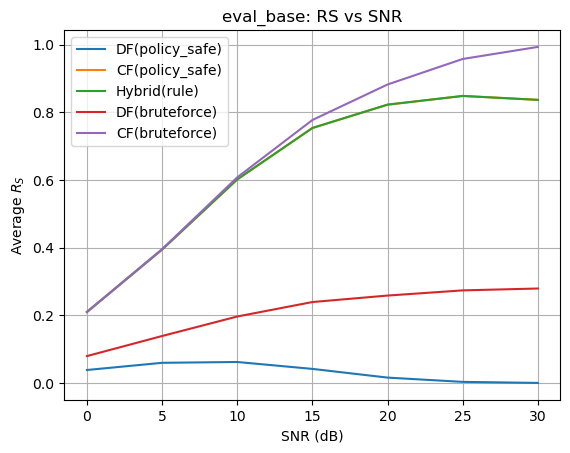

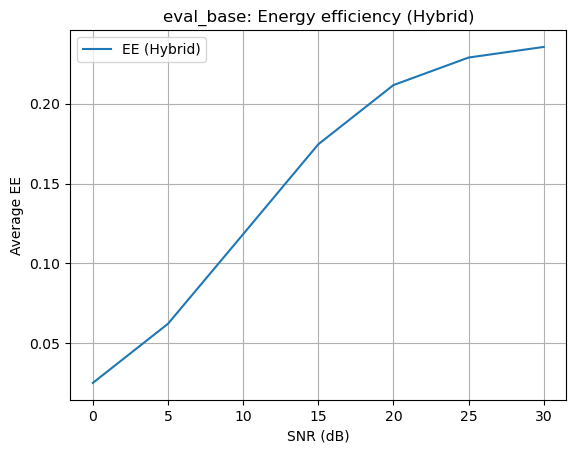

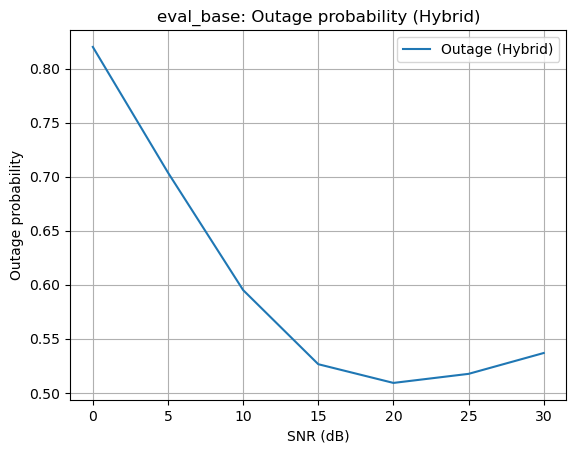

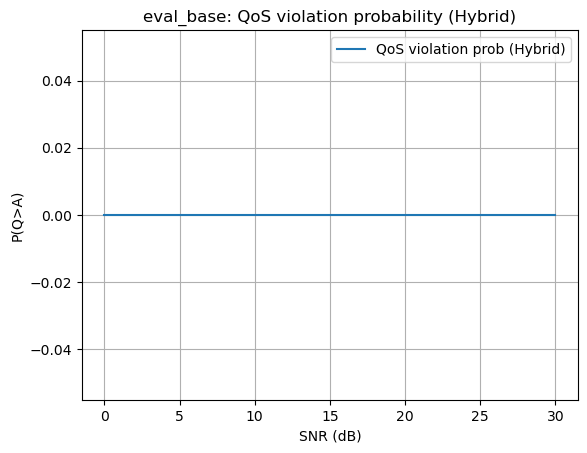

Saved: outputs\final_all\eval_base\results\full_system_snr.json
Saved: outputs\final_all\eval_base\figures\rs_vs_snr.png
GenRob ckpts: outputs\final_all\df_genrob\checkpoints\best.pt outputs\final_all\cf_genrob\checkpoints\best.pt


eval:eval_genrob: 100%|███████████████████████████| 7/7 [02:11<00:00, 18.72s/it, SNR=30, HY=0.867, CFb=0.986, Out=0.50]


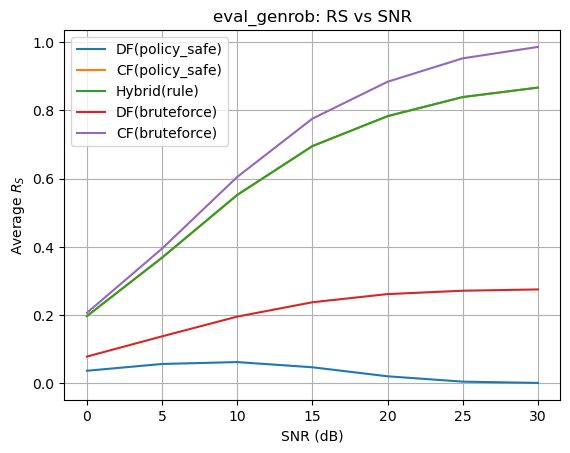

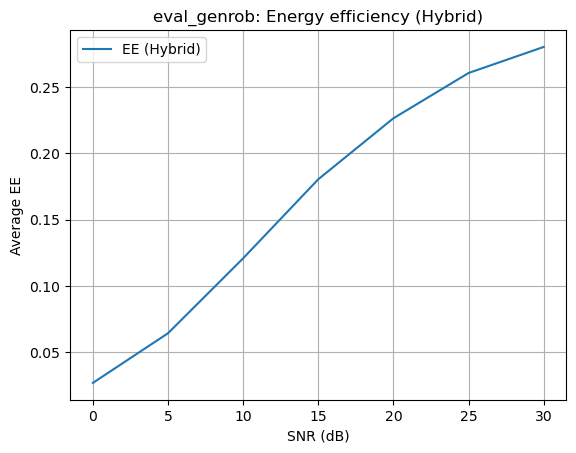

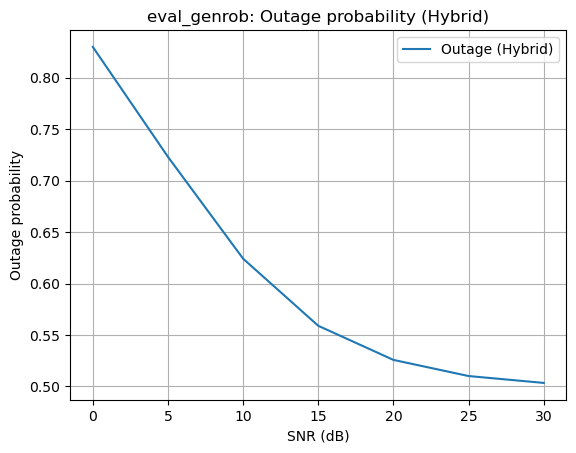

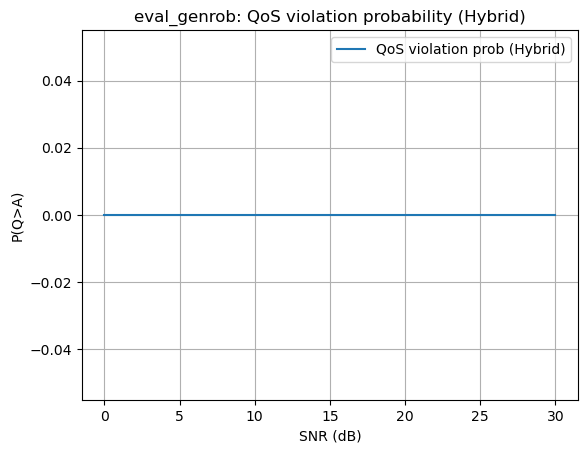

Saved: outputs\final_all\eval_genrob\results\full_system_snr.json
Saved: outputs\final_all\eval_genrob\figures\rs_vs_snr.png


In [14]:
# Evaluate base models (DF/CF/hybrid/rule) and brute-force baselines

def evaluate_full(
    *,
    tag: str,
    df_model,
    cf_model,
    generalized: bool,
    apply_policy_safety: bool = True,
    df_grid=DFGrid(**DF_GRID),
    cf_grid=CFGrid(**CF_GRID),
):
    ap = make_artifacts(tag)

    curves = {
        "DF(policy_safe)": [],
        "CF(policy_safe)": [],
        "Hybrid(rule)": [],
        "DF(bruteforce)": [],
        "CF(bruteforce)": [],
    }
    curves_extra = {
        "EE_Hybrid": [],
        "Outage_Hybrid": [],
        "QoSviolProb_Hybrid": [],
    }

    feat = FeatureConfig(include_system=bool(generalized))

    pbar = tqdm(SNR_DB, desc=f"eval:{tag}", dynamic_ncols=True)
    for snr in pbar:
        # accumulators
        rs_df, rs_cf, rs_hy = [], [], []
        rs_dfb, rs_cfb = [], []
        ee_hy, out_hy, qprob_hy = [], [], []

        for _ in range(EVAL_STEPS):
            g = generate_gains(int(EVAL_BATCH), ch["model"], device, geo=geo, fad=fad, mixed_weights=ch.get("mixed", {}).get("weights"))
            g = _snr_scale(g, snr)

            B = int(EVAL_BATCH)
            tau = torch.full((B,), float(df_cfg["tau"]), device=device)
            ps_max = torch.full((B,), float(df_cfg["power"]["Ps_max"]), device=device)
            pr_max = torch.full((B,), float(df_cfg["power"]["Pr_max"]), device=device)

            if generalized:
                x = build_features(g, feat, tau=tau, ps_max=ps_max, pr_max=pr_max)
            else:
                x = build_features(g, feat)

            # policy actions
            ps_df_p, pr_df_p, a_df_p, *_ = _policy_actions_df(df_model, x, ps_max, pr_max)
            ps_cf_p, pr_cf_p, *_ = _policy_actions_cf(cf_model, x, ps_max, pr_max)

            # policy+safe metrics
            rs_df_t, _, _, _ = _metrics_df(g, ps_df_p, pr_df_p, a_df_p, dfp_nom, apply_safety=apply_policy_safety)
            rs_cf_t, _, _, _ = _metrics_cf(g, ps_cf_p, pr_cf_p, cfp_nom, apply_safety=apply_policy_safety)

            # hybrid(rule)
            hy = select_best_scheme(
                g,
                df_action={"ps": ps_df_p, "pr": pr_df_p, "alpha": a_df_p},
                cf_action={"ps": ps_cf_p, "pr": pr_cf_p},
                df_params=dfp_nom,
                cf_params=cfp_nom,
                safety=True,
            )
            rs_h = torch.where(hy["scheme"] > 0.5, hy["rs_df"], hy["rs_cf"])
            # compute hybrid metrics (use chosen actions already safety-scaled internally)
            # We approximate metrics using rs_h and chosen ps/pr; alpha=0 for CF branch
            ee = ee_secondary(rs_h, hy["ps"], hy["pr"])
            out = outage_hard(rs_h, rs_th)
            # QoS violation prob: compute both Q and A for the chosen scheme
            # Conservative: compute DF violation for DF-chosen and CF violation for CF-chosen
            A_df = qos_A_df(g["PP"], dfp_nom); Q_df = qos_Q_df(g, hy["ps"], hy["pr"], hy["alpha"]); viol_df = qos_violation(Q_df, A_df)
            A_cf = qos_A_cf(g["PP"], cfp_nom); Q_cf = qos_Q_cf(g, hy["ps"], hy["pr"]);               viol_cf = qos_violation(Q_cf, A_cf)
            viol = torch.where(hy["scheme"] > 0.5, viol_df, viol_cf)

            # brute-force baselines
            df_sol = solve_df_bruteforce(g, float(df_cfg["power"]["Ps_max"]), float(df_cfg["power"]["Pr_max"]), dfp_nom, df_grid)
            cf_sol = solve_cf_bruteforce(g, float(cf_cfg["power"]["Ps_max"]), float(cf_cfg["power"]["Pr_max"]), cfp_nom, cf_grid)
            rs_cf_b, _, _, _ = _metrics_cf(g, cf_sol["ps"], cf_sol["pr"], cfp_nom, apply_safety=False)

            rs_df.append(float(rs_df_t.mean().item()))
            rs_cf.append(float(rs_cf_t.mean().item()))
            rs_hy.append(float(rs_h.mean().item()))
            rs_dfb.append(float(df_sol["rs"].mean().item()))
            rs_cfb.append(float(rs_cf_b.mean().item()))

            ee_hy.append(float(ee.mean().item()))
            out_hy.append(float(out.mean().item()))
            qprob_hy.append(float((viol > 0).float().mean().item()))

        curves["DF(policy_safe)"].append(float(np.mean(rs_df)))
        curves["CF(policy_safe)"].append(float(np.mean(rs_cf)))
        curves["Hybrid(rule)"].append(float(np.mean(rs_hy)))
        curves["DF(bruteforce)"].append(float(np.mean(rs_dfb)))
        curves["CF(bruteforce)"].append(float(np.mean(rs_cfb)))

        curves_extra["EE_Hybrid"].append(float(np.mean(ee_hy)))
        curves_extra["Outage_Hybrid"].append(float(np.mean(out_hy)))
        curves_extra["QoSviolProb_Hybrid"].append(float(np.mean(qprob_hy)))

        pbar.set_postfix({
            "SNR": snr,
            "HY": f"{curves['Hybrid(rule)'][-1]:.3f}",
            "CFb": f"{curves['CF(bruteforce)'][-1]:.3f}",
            "Out": f"{curves_extra['Outage_Hybrid'][-1]:.2f}",
        })

    payload = {"snr_db": SNR_DB, "rs": curves, "extra": curves_extra}
    (ap.results / "full_system_snr.json").write_text(json.dumps(payload, indent=2), encoding="utf-8")

    # Plots
    plt.figure()
    for k, v in curves.items():
        plt.plot(SNR_DB, v, label=k)
    plt.xlabel("SNR (dB)")
    plt.ylabel("Average $R_S$")
    plt.title(f"{tag}: RS vs SNR")
    plt.grid(True)
    plt.legend()
    fig1 = ap.figures / "rs_vs_snr.png"
    plt.savefig(fig1, dpi=200, bbox_inches="tight")
    plt.show()

    plt.figure()
    plt.plot(SNR_DB, curves_extra["EE_Hybrid"], label="EE (Hybrid)")
    plt.xlabel("SNR (dB)")
    plt.ylabel("Average EE")
    plt.title(f"{tag}: Energy efficiency (Hybrid)")
    plt.grid(True)
    plt.legend()
    fig2 = ap.figures / "ee_hybrid.png"
    plt.savefig(fig2, dpi=200, bbox_inches="tight")
    plt.show()

    plt.figure()
    plt.plot(SNR_DB, curves_extra["Outage_Hybrid"], label="Outage (Hybrid)")
    plt.xlabel("SNR (dB)")
    plt.ylabel("Outage probability")
    plt.title(f"{tag}: Outage probability (Hybrid)")
    plt.grid(True)
    plt.legend()
    fig3 = ap.figures / "outage_hybrid.png"
    plt.savefig(fig3, dpi=200, bbox_inches="tight")
    plt.show()

    plt.figure()
    plt.plot(SNR_DB, curves_extra["QoSviolProb_Hybrid"], label="QoS violation prob (Hybrid)")
    plt.xlabel("SNR (dB)")
    plt.ylabel("P(Q>A)")
    plt.title(f"{tag}: QoS violation probability (Hybrid)")
    plt.grid(True)
    plt.legend()
    fig4 = ap.figures / "qosviolprob_hybrid.png"
    plt.savefig(fig4, dpi=200, bbox_inches="tight")
    plt.show()

    print("Saved:", ap.results / "full_system_snr.json")
    print("Saved:", fig1)
    return ap, payload

base_eval = None
genrob_eval = None

if RUN_EVALUATION:
    if base_df_paths and base_cf_paths:
        df_loaded, df_ckpt = _load_ckpt(DFPolicy(in_dim=8), base_df_paths)
        cf_loaded, cf_ckpt = _load_ckpt(CFPolicy(in_dim=8), base_cf_paths)
        print("Base ckpts:", df_ckpt, cf_ckpt)
        base_eval, base_payload = evaluate_full(tag="eval_base", df_model=df_loaded, cf_model=cf_loaded, generalized=False)
    if genrob_df_paths and genrob_cf_paths:
        df_loaded, df_ckpt = _load_ckpt(GeneralizedDFPolicy(in_dim=11), genrob_df_paths)
        cf_loaded, cf_ckpt = _load_ckpt(GeneralizedCFPolicy(in_dim=11), genrob_cf_paths)
        print("GenRob ckpts:", df_ckpt, cf_ckpt)
        genrob_eval, genrob_payload = evaluate_full(tag="eval_genrob", df_model=df_loaded, cf_model=cf_loaded, generalized=True)
else:
    print("Skipping evaluation.")


## Robustness Evaluation (CSI noise sweep)

### Setup
We evaluate robustness to CSI estimation errors by generating paired channel gains
$$
(\mathbf{g}_{\mathrm{imp}},\ \mathbf{g}_{\mathrm{ref}}),
$$
where $\mathbf{g}_{\mathrm{imp}}$ is an imperfect observation and $\mathbf{g}_{\mathrm{ref}}$ is the reference (perfect) gain vector.

### Protocol
For each noise level $\sigma$, the policy observes
$$
x_{\mathrm{imp}} = [\mathbf{g}_{\mathrm{imp}},\ \tau,\ P_{S,\max},\ P_{R,\max}],
$$
while the physics-based metrics and constraint checks are computed using $\mathbf{g}_{\mathrm{ref}}$:
$$
R_S = R_S(\mathbf{g}_{\mathrm{ref}}, P_S, P_R, \alpha), \qquad Q = Q(\mathbf{g}_{\mathrm{ref}}, P_S, P_R, \alpha).
$$

We report the hybrid performance (with safety enabled) as a function of $\sigma$, including mean $R_S$, outage probability, QoS violation probability, and mean energy efficiency.

C:\Users\haith\AppData\Local\Temp\ipykernel_1372\1155363360.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sd = torch.load(ckpt, map_location=device)["model_state"]


,sigma,rs_hybrid,outage,qos_viol_prob,ee
0,0.00,0.824846,0.508087,0.0,0.210547
1,0.05,0.827864,0.508177,0.0,0.211247
2,0.10,0.823666,0.509536,0.0,0.209553
3,0.15,0.826350,0.509721,0.0,0.212314
4,0.20,0.830133,0.508007,0.0,0.211707


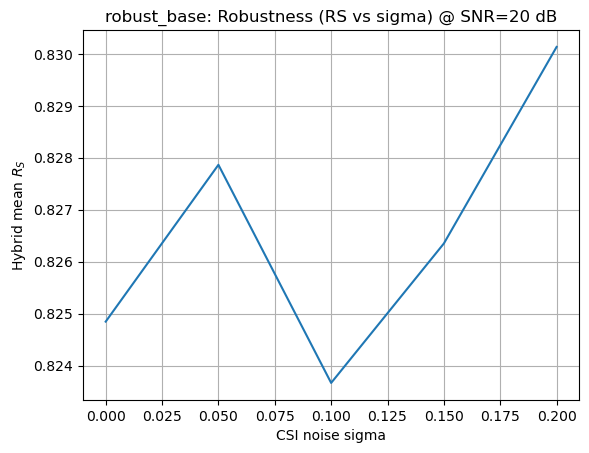

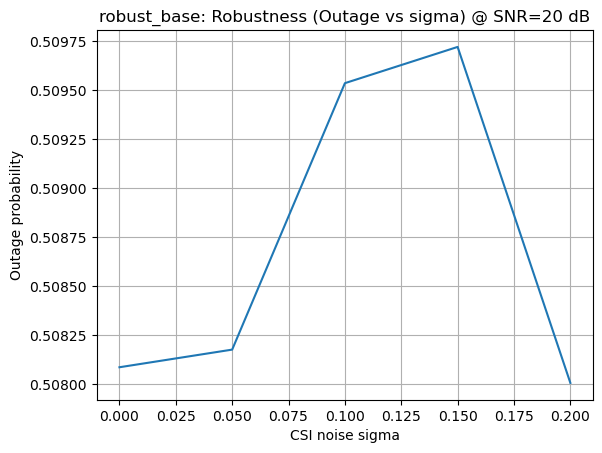

C:\Users\haith\AppData\Local\Temp\ipykernel_1372\1155363360.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sd = torch.load(ckpt, map_location=device)["model_state"]


,sigma,rs_hybrid,outage,qos_viol_prob,ee
0,0.00,0.789062,0.525466,0.0,0.228466
1,0.05,0.782162,0.526839,0.0,0.228126
2,0.10,0.788164,0.524796,0.0,0.229935
3,0.15,0.781552,0.525241,0.0,0.227894
4,0.20,0.785165,0.525111,0.0,0.229423


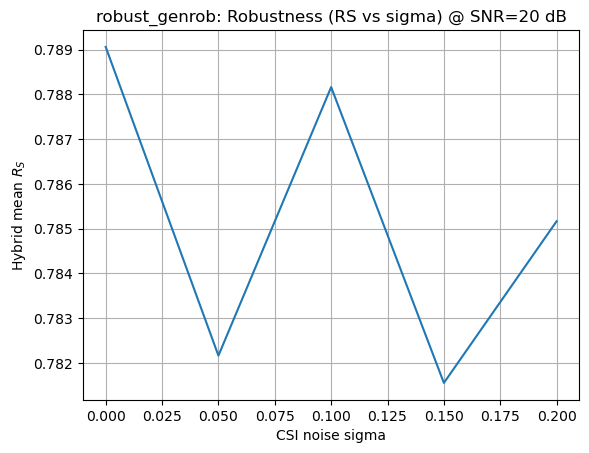

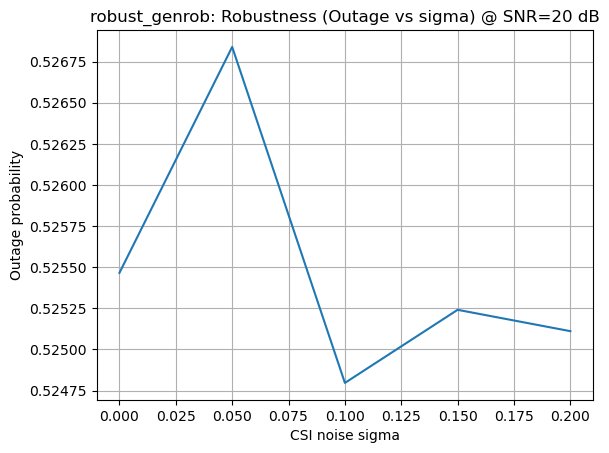

In [15]:
# Robustness: compare base vs genrob under imperfect CSI at fixed SNR

def eval_robust_sigma(tag: str, df_model, cf_model, generalized: bool, sigmas):
    ap = make_artifacts(tag)

    rows = []
    feat = FeatureConfig(include_system=bool(generalized))

    for sigma in sigmas:
        rs_hy_list = []
        out_list = []
        qprob_list = []
        ee_list = []

        for _ in range(EVAL_STEPS):
            g = generate_gains(int(EVAL_BATCH), ch["model"], device, geo=geo, fad=fad, mixed_weights=ch.get("mixed", {}).get("weights"))
            g = _snr_scale(g, GEN_EVAL_SNR_DB)

            # Imperfect observation for input
            icfg = ImperfectCSIConfig(sigma=float(sigma), apply_to_links=tuple(cfg["robust"]["noise"]["apply_to_links"]), clamp_min=float(cfg["robust"]["noise"]["clamp_min"]))
            g_imp, g_ref = make_imperfect_pair(g, icfg)

            B = int(EVAL_BATCH)
            tau = torch.full((B,), float(df_cfg["tau"]), device=device)
            ps_max = torch.full((B,), float(df_cfg["power"]["Ps_max"]), device=device)
            pr_max = torch.full((B,), float(df_cfg["power"]["Pr_max"]), device=device)

            if generalized:
                x = build_features(g_imp, feat, tau=tau, ps_max=ps_max, pr_max=pr_max)
            else:
                x = build_features(g_imp, feat)

            ps_df_p, pr_df_p, a_df_p, *_ = _policy_actions_df(df_model, x, ps_max, pr_max)
            ps_cf_p, pr_cf_p, *_ = _policy_actions_cf(cf_model, x, ps_max, pr_max)

            hy = select_best_scheme(
                g_ref,
                df_action={"ps": ps_df_p, "pr": pr_df_p, "alpha": a_df_p},
                cf_action={"ps": ps_cf_p, "pr": pr_cf_p},
                df_params=dfp_nom,
                cf_params=cfp_nom,
                safety=True,
            )
            rs_h = torch.where(hy["scheme"] > 0.5, hy["rs_df"], hy["rs_cf"])
            ee = ee_secondary(rs_h, hy["ps"], hy["pr"])
            out = outage_hard(rs_h, rs_th)

            A_df = qos_A_df(g_ref["PP"], dfp_nom); Q_df = qos_Q_df(g_ref, hy["ps"], hy["pr"], hy["alpha"]); viol_df = qos_violation(Q_df, A_df)
            A_cf = qos_A_cf(g_ref["PP"], cfp_nom); Q_cf = qos_Q_cf(g_ref, hy["ps"], hy["pr"]);               viol_cf = qos_violation(Q_cf, A_cf)
            viol = torch.where(hy["scheme"] > 0.5, viol_df, viol_cf)

            rs_hy_list.append(float(rs_h.mean().item()))
            out_list.append(float(out.mean().item()))
            qprob_list.append(float((viol > 0).float().mean().item()))
            ee_list.append(float(ee.mean().item()))

        rows.append({
            "sigma": sigma,
            "rs_hybrid": float(np.mean(rs_hy_list)),
            "outage": float(np.mean(out_list)),
            "qos_viol_prob": float(np.mean(qprob_list)),
            "ee": float(np.mean(ee_list)),
        })

    df_res = pd.DataFrame(rows)
    df_res.to_csv(ap.results / "robust_sigma.csv", index=False)
    display(df_res)

    # plots
    plt.figure()
    plt.plot(df_res["sigma"], df_res["rs_hybrid"])
    plt.xlabel("CSI noise sigma")
    plt.ylabel("Hybrid mean $R_S$")
    plt.title(f"{tag}: Robustness (RS vs sigma) @ SNR={GEN_EVAL_SNR_DB} dB")
    plt.grid(True)
    fig1 = ap.figures / "rs_vs_sigma.png"
    plt.savefig(fig1, dpi=200, bbox_inches="tight")
    plt.show()

    plt.figure()
    plt.plot(df_res["sigma"], df_res["outage"])
    plt.xlabel("CSI noise sigma")
    plt.ylabel("Outage probability")
    plt.title(f"{tag}: Robustness (Outage vs sigma) @ SNR={GEN_EVAL_SNR_DB} dB")
    plt.grid(True)
    fig2 = ap.figures / "outage_vs_sigma.png"
    plt.savefig(fig2, dpi=200, bbox_inches="tight")
    plt.show()

    return ap, df_res

if RUN_EVALUATION and base_df_paths and base_cf_paths:
    df_loaded, _ = _load_ckpt(DFPolicy(in_dim=8), base_df_paths)
    cf_loaded, _ = _load_ckpt(CFPolicy(in_dim=8), base_cf_paths)
    _ = eval_robust_sigma("robust_base", df_loaded, cf_loaded, generalized=False, sigmas=ROBUST_SIGMAS)

if RUN_EVALUATION and genrob_df_paths and genrob_cf_paths:
    df_loaded, _ = _load_ckpt(GeneralizedDFPolicy(in_dim=11), genrob_df_paths)
    cf_loaded, _ = _load_ckpt(GeneralizedCFPolicy(in_dim=11), genrob_cf_paths)
    _ = eval_robust_sigma("robust_genrob", df_loaded, cf_loaded, generalized=True, sigmas=ROBUST_SIGMAS)


## Generalization Evaluation (system parameters sweep)

### Setup
We evaluate generalization across operating conditions by sweeping key system parameters:
$$
\tau,\quad P_{S,\max},\quad P_{R,\max}.
$$

### Protocol
For each operating point $(\tau, P_{S,\max}, P_{R,\max})$, we build a system-conditioned input
$$
x = [\mathbf{g},\ \tau,\ P_{S,\max},\ P_{R,\max}] \in \mathbb{R}^{11},
$$
run the DF and CF policies, apply the safety layer, and select the best relaying mode.

### Reported metrics
At each operating point we report the hybrid performance, including:
- mean secondary rate $\mathbb{E}[R_S]$,
- mean energy efficiency $\mathbb{E}[EE]$,
- outage probability $\mathbb{P}(R_S < R_{S,\mathrm{th}})$.

C:\Users\haith\AppData\Local\Temp\ipykernel_1372\1155363360.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sd = torch.load(ckpt, map_location=device)["model_state"]


,tau,Ps_max,Pr_max,rs_hybrid,ee,outage
0,0.1,2.0,2.0,0.631621,0.295216,0.552340
1,0.1,2.0,5.0,0.708230,0.296138,0.522633
2,0.1,2.0,10.0,0.764863,0.290950,0.505330
3,0.1,5.0,2.0,0.693514,0.234051,0.537539
4,0.1,5.0,5.0,0.764080,0.248664,0.509241


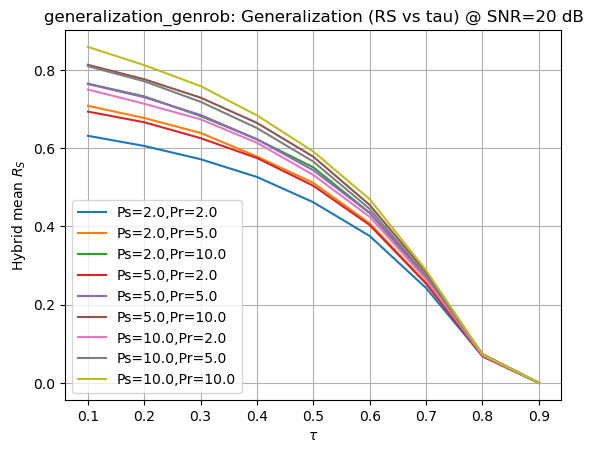

In [16]:
# Generalization: evaluate genrob model across (tau, Ps_max, Pr_max)

def eval_generalization(tag: str, df_model, cf_model):
    ap = make_artifacts(tag)
    feat = FeatureConfig(include_system=True)

    rows = []
    for tau0 in TAU_GRID:
        for ps0 in PS_MAX_GRID:
            for pr0 in PR_MAX_GRID:
                rs_hy_list = []
                out_list = []
                ee_list = []

                for _ in range(EVAL_STEPS):
                    g = generate_gains(int(EVAL_BATCH), ch["model"], device, geo=geo, fad=fad, mixed_weights=ch.get("mixed", {}).get("weights"))
                    g = _snr_scale(g, GEN_EVAL_SNR_DB)

                    B = int(EVAL_BATCH)
                    tau = torch.full((B,), float(tau0), device=device)
                    ps_max = torch.full((B,), float(ps0), device=device)
                    pr_max = torch.full((B,), float(pr0), device=device)

                    x = build_features(g, feat, tau=tau, ps_max=ps_max, pr_max=pr_max)

                    ps_df_p, pr_df_p, a_df_p, *_ = _policy_actions_df(df_model, x, ps_max, pr_max)
                    ps_cf_p, pr_cf_p, *_ = _policy_actions_cf(cf_model, x, ps_max, pr_max)

                    dfp = DFParams(tau=float(tau0), noise_power=dfp_nom.noise_power, Pp=dfp_nom.Pp, Rp0=dfp_nom.Rp0)
                    cfp = CFParams(tau=float(tau0), noise_power=cfp_nom.noise_power, Pp=cfp_nom.Pp, Rp0=cfp_nom.Rp0)

                    hy = select_best_scheme(
                        g,
                        df_action={"ps": ps_df_p, "pr": pr_df_p, "alpha": a_df_p},
                        cf_action={"ps": ps_cf_p, "pr": pr_cf_p},
                        df_params=dfp,
                        cf_params=cfp,
                        safety=True,
                    )
                    rs_h = torch.where(hy["scheme"] > 0.5, hy["rs_df"], hy["rs_cf"])
                    ee = ee_secondary(rs_h, hy["ps"], hy["pr"])
                    out = outage_hard(rs_h, rs_th)

                    rs_hy_list.append(float(rs_h.mean().item()))
                    ee_list.append(float(ee.mean().item()))
                    out_list.append(float(out.mean().item()))

                rows.append({
                    "tau": float(tau0),
                    "Ps_max": float(ps0),
                    "Pr_max": float(pr0),
                    "rs_hybrid": float(np.mean(rs_hy_list)),
                    "ee": float(np.mean(ee_list)),
                    "outage": float(np.mean(out_list)),
                })

    df_res = pd.DataFrame(rows)
    df_res.to_csv(ap.results / "generalization_grid.csv", index=False)
    display(df_res.head())

    # Plot: RS vs tau for each (Ps_max, Pr_max)
    plt.figure()
    for ps0 in PS_MAX_GRID:
        for pr0 in PR_MAX_GRID:
            sub = df_res[(df_res["Ps_max"] == ps0) & (df_res["Pr_max"] == pr0)].sort_values("tau")
            plt.plot(sub["tau"], sub["rs_hybrid"], label=f"Ps={ps0},Pr={pr0}")
    plt.xlabel(r"$\tau$")
    plt.ylabel("Hybrid mean $R_S$")
    plt.title(f"{tag}: Generalization (RS vs tau) @ SNR={GEN_EVAL_SNR_DB} dB")
    plt.grid(True)
    plt.legend()
    fig1 = ap.figures / "rs_vs_tau.png"
    plt.savefig(fig1, dpi=200, bbox_inches="tight")
    plt.show()

    return ap, df_res

if RUN_EVALUATION and genrob_df_paths and genrob_cf_paths:
    df_loaded, _ = _load_ckpt(GeneralizedDFPolicy(in_dim=11), genrob_df_paths)
    cf_loaded, _ = _load_ckpt(GeneralizedCFPolicy(in_dim=11), genrob_cf_paths)
    _ = eval_generalization("generalization_genrob", df_loaded, cf_loaded)


## Selector Network (Supervised)

We train a classifier \(p_{\theta}(\text{DF}\mid x)\) with BCE loss against oracle labels:
$$
y=\mathbb{1}\{R_S^{\text{DF,oracle}}\ge R_S^{\text{CF,oracle}}\},\quad
\mathcal{L}_{\text{BCE}}=-y\log p-(1-y)\log(1-p).
$$


In [17]:
# Train selector net + threshold tuning

def build_selector_features(g, df_model, cf_model, generalized: bool, include_policy_outputs: bool):
    B = g["PP"].shape[0]
    tau = torch.full((B,), float(df_cfg["tau"]), device=device)
    ps_max = torch.full((B,), float(df_cfg["power"]["Ps_max"]), device=device)
    pr_max = torch.full((B,), float(df_cfg["power"]["Pr_max"]), device=device)

    feat = FeatureConfig(include_system=bool(generalized))
    if generalized:
        x = build_features(g, feat, tau=tau, ps_max=ps_max, pr_max=pr_max)
    else:
        x = build_features(g, feat)

    if not include_policy_outputs:
        return x, tau, ps_max, pr_max

    # Append policy outputs (gammas) to selector features
    ps_df, pr_df, a_df, gps_df, gpr_df = _policy_actions_df(df_model, x, ps_max, pr_max)
    ps_cf, pr_cf, gps_cf, gpr_cf = _policy_actions_cf(cf_model, x, ps_max, pr_max)

    extras = torch.stack([gps_df, gpr_df, a_df, gps_cf, gpr_cf], dim=-1)  # [B,5]
    x_sel = torch.cat([x, extras], dim=-1)
    return x_sel, tau, ps_max, pr_max

def train_selector(tag: str, df_model, cf_model, generalized: bool):
    ap = make_artifacts(tag)

    # Build one large dataset batch (oracle from brute force)
    B = max(BATCH_SELECTOR, 2048)
    g = generate_gains(int(B), ch["model"], device, geo=geo, fad=fad, mixed_weights=ch.get("mixed", {}).get("weights"))
    X, _, _, _ = build_selector_features(g, df_model, cf_model, generalized, SELECTOR_INCLUDE_POLICY_OUTPUTS)

    # Oracle labels
    df_sol = solve_df_bruteforce(g, float(df_cfg["power"]["Ps_max"]), float(df_cfg["power"]["Pr_max"]), dfp_nom, DFGrid(ps_steps=13, pr_steps=13, alpha_steps=7))
    cf_sol = solve_cf_bruteforce(g, float(cf_cfg["power"]["Ps_max"]), float(cf_cfg["power"]["Pr_max"]), cfp_nom, CFGrid(ps_steps=21, pr_steps=21))
    rs_cf = secondary_rate_cf(g, cf_sol["ps"], cf_sol["pr"], cfp_nom)
    y = (df_sol["rs"] >= rs_cf).float()

    # DataLoader
    ds = torch.utils.data.TensorDataset(X.detach().cpu(), y.detach().cpu())
    dl = torch.utils.data.DataLoader(ds, batch_size=min(512, BATCH_SELECTOR), shuffle=True, drop_last=False)

    net = SelectorNet(in_dim=X.shape[1]).to(device)
    opt = torch.optim.AdamW(net.parameters(), lr=1e-3, weight_decay=1e-4)
    bce = torch.nn.BCELoss()

    pbar = tqdm(range(1, EPOCHS_SELECTOR + 1), desc=f"train:{tag}", dynamic_ncols=True)
    for ep in pbar:
        net.train()
        losses = []
        accs = []
        for xb, yb in dl:
            xb = xb.to(device)
            yb = yb.to(device)
            opt.zero_grad(set_to_none=True)
            p = net(xb)
            loss = bce(p, yb)
            loss.backward()
            opt.step()
            losses.append(loss.detach())
            accs.append(((p >= 0.5).float() == yb).float().mean().detach())
        loss_m = torch.stack(losses).mean().item()
        acc_m = torch.stack(accs).mean().item()
        pbar.set_postfix({"loss": f"{loss_m:.4f}", "acc": f"{acc_m:.3f}"})

    # Threshold tuning on same batch
    net.eval()
    with torch.no_grad():
        p_df = net(X)
    t_grid = cfg["selector"]["threshold"]["grid"]
    best_t, info = tune_threshold(p_df, df_sol["rs"], rs_cf, t_grid)
    info["best_t"] = best_t

    torch.save({"model_state": net.state_dict(), "best_t": best_t, "in_dim": int(X.shape[1])}, ap.checkpoints / "selector.pt")
    (ap.results / "threshold_tuning.json").write_text(json.dumps(info, indent=2), encoding="utf-8")

    print("best_t:", best_t, "best_mean_rs:", info["best_rs"])
    return ap, net, best_t

selector_ap = None
selector_net = None
selector_t = 0.5

if RUN_SELECTOR_TRAIN and RUN_EVALUATION and base_df_paths and base_cf_paths:
    df_loaded, _ = _load_ckpt(DFPolicy(in_dim=8), base_df_paths)
    cf_loaded, _ = _load_ckpt(CFPolicy(in_dim=8), base_cf_paths)
    selector_ap, selector_net, selector_t = train_selector("selector_base", df_loaded, cf_loaded, generalized=False)


C:\Users\haith\AppData\Local\Temp\ipykernel_1372\1155363360.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sd = torch.load(ckpt, map_location=device)["model_state"]
tr

best_t: 0.9 best_mean_rs: 0.2101154327392578


## Selector Evaluation (vs rule vs oracle)

We compare:
- Rule‑based hybrid
- Learned selector + safety
- Oracle (choose best of brute‑force DF/CF per sample)


C:\Users\haith\AppData\Local\Temp\ipykernel_1372\1155363360.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sd = torch.load(ckpt, map_location=device)["model_state"]
ev

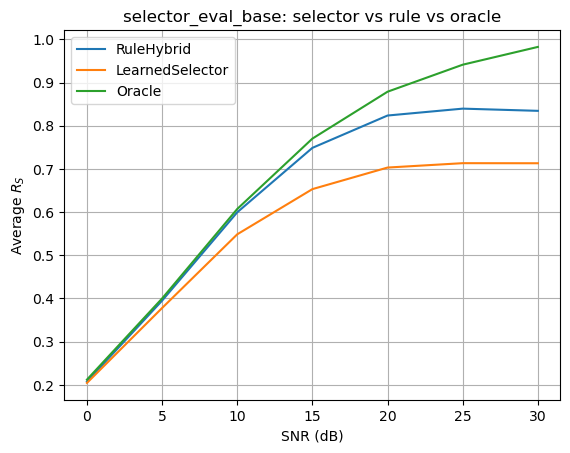

Saved: outputs\final_all\selector_eval_base\figures\selector_vs_rule.png


In [18]:
# Evaluate selector across SNR (base models)

def eval_selector(tag: str, df_model, cf_model, net: SelectorNet, threshold: float, generalized: bool):
    ap = make_artifacts(tag)
    feat_g = FeatureConfig(include_system=bool(generalized))

    curves = {"RuleHybrid": [], "LearnedSelector": [], "Oracle": []}

    for snr in tqdm(SNR_DB, desc=f"eval:{tag}", dynamic_ncols=True):
        rs_rule, rs_sel, rs_oracle = [], [], []

        for _ in range(EVAL_STEPS):
            g = generate_gains(int(EVAL_BATCH), ch["model"], device, geo=geo, fad=fad, mixed_weights=ch.get("mixed", {}).get("weights"))
            g = _snr_scale(g, snr)
            B = int(EVAL_BATCH)

            tau = torch.full((B,), float(df_cfg["tau"]), device=device)
            ps_max = torch.full((B,), float(df_cfg["power"]["Ps_max"]), device=device)
            pr_max = torch.full((B,), float(df_cfg["power"]["Pr_max"]), device=device)

            if generalized:
                x = build_features(g, feat_g, tau=tau, ps_max=ps_max, pr_max=pr_max)
            else:
                x = build_features(g, feat_g)

            ps_df, pr_df, a_df, gps_df, gpr_df = _policy_actions_df(df_model, x, ps_max, pr_max)
            ps_cf, pr_cf, gps_cf, gpr_cf = _policy_actions_cf(cf_model, x, ps_max, pr_max)

            # Rule hybrid
            hy = select_best_scheme(
                g,
                df_action={"ps": ps_df, "pr": pr_df, "alpha": a_df},
                cf_action={"ps": ps_cf, "pr": pr_cf},
                df_params=dfp_nom,
                cf_params=cfp_nom,
                safety=True,
            )
            rs_h = torch.where(hy["scheme"] > 0.5, hy["rs_df"], hy["rs_cf"])

            # Learned selector feature
            if SELECTOR_INCLUDE_POLICY_OUTPUTS:
                extras = torch.stack([gps_df, gpr_df, a_df, gps_cf, gpr_cf], dim=-1)
                x_sel = torch.cat([x, extras], dim=-1)
            else:
                x_sel = x

            p_df = net(x_sel)
            choose_df = p_df >= float(threshold)

            # Apply safety + compute RS for chosen scheme
            # DF metrics
            rs_df_s, _, _, _ = _metrics_df(g, ps_df, pr_df, a_df, dfp_nom, apply_safety=True)
            rs_cf_s, _, _, _ = _metrics_cf(g, ps_cf, pr_cf, cfp_nom, apply_safety=True)
            rs_l = torch.where(choose_df, rs_df_s, rs_cf_s)

            # Oracle from brute force
            df_sol = solve_df_bruteforce(g, float(df_cfg["power"]["Ps_max"]), float(df_cfg["power"]["Pr_max"]), dfp_nom, DFGrid(ps_steps=13, pr_steps=13, alpha_steps=7))
            cf_sol = solve_cf_bruteforce(g, float(cf_cfg["power"]["Ps_max"]), float(cf_cfg["power"]["Pr_max"]), cfp_nom, CFGrid(ps_steps=21, pr_steps=21))
            rs_cf_or, _, _, _ = _metrics_cf(g, cf_sol["ps"], cf_sol["pr"], cfp_nom, apply_safety=False)
            rs_or = torch.where(df_sol["rs"] >= rs_cf_or, df_sol["rs"], rs_cf_or)

            rs_rule.append(float(rs_h.mean().item()))
            rs_sel.append(float(rs_l.mean().item()))
            rs_oracle.append(float(rs_or.mean().item()))

        curves["RuleHybrid"].append(float(np.mean(rs_rule)))
        curves["LearnedSelector"].append(float(np.mean(rs_sel)))
        curves["Oracle"].append(float(np.mean(rs_oracle)))

    (ap.results / "selector_snr.json").write_text(json.dumps({"snr_db": SNR_DB, "rs": curves, "threshold": float(threshold)}, indent=2), encoding="utf-8")

    plt.figure()
    for k, v in curves.items():
        plt.plot(SNR_DB, v, label=k)
    plt.xlabel("SNR (dB)")
    plt.ylabel("Average $R_S$")
    plt.title(f"{tag}: selector vs rule vs oracle")
    plt.grid(True)
    plt.legend()
    fig = ap.figures / "selector_vs_rule.png"
    plt.savefig(fig, dpi=200, bbox_inches="tight")
    plt.show()
    print("Saved:", fig)

    return ap, curves

if RUN_EVALUATION and selector_net is not None and base_df_paths and base_cf_paths:
    df_loaded, _ = _load_ckpt(DFPolicy(in_dim=8), base_df_paths)
    cf_loaded, _ = _load_ckpt(CFPolicy(in_dim=8), base_cf_paths)
    _ = eval_selector("selector_eval_base", df_loaded, cf_loaded, selector_net, selector_t, generalized=False)


## Deployment Indicators

We report:
- parameter count and model size
- latency vs batch size on the active device
- TorchScript and ONNX export


C:\Users\haith\AppData\Local\Temp\ipykernel_1372\1155363360.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sd = torch.load(ckpt, map_location=device)["model_state"]


,total_params,trainable_params,size_mb
0,101379,101379,0.38673


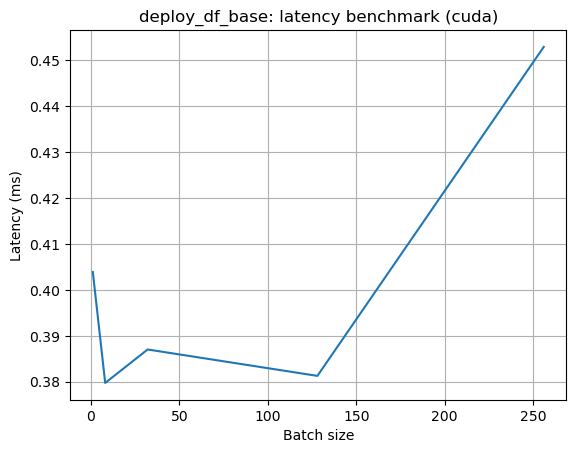

TorchScript export failed: export_torchscript() got an unexpected keyword argument 'in_dim'
ONNX export failed: export_onnx() got an unexpected keyword argument 'in_dim'


C:\Users\haith\AppData\Local\Temp\ipykernel_1372\1155363360.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sd = torch.load(ckpt, map_location=device)["model_state"]


,total_params,trainable_params,size_mb
0,101250,101250,0.386238


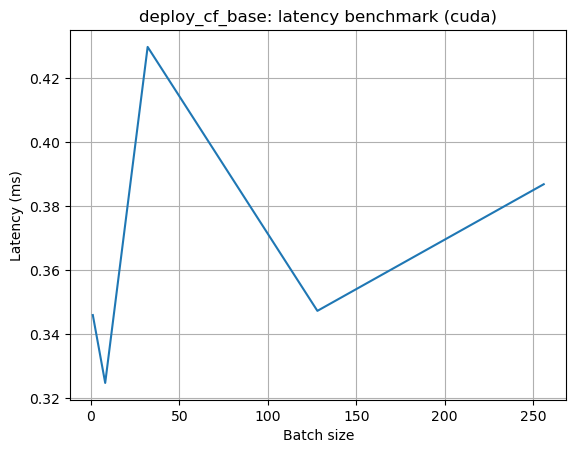

TorchScript export failed: export_torchscript() got an unexpected keyword argument 'in_dim'
ONNX export failed: export_onnx() got an unexpected keyword argument 'in_dim'


C:\Users\haith\AppData\Local\Temp\ipykernel_1372\1155363360.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sd = torch.load(ckpt, map_location=device)["model_state"]


,total_params,trainable_params,size_mb
0,102147,102147,0.38966


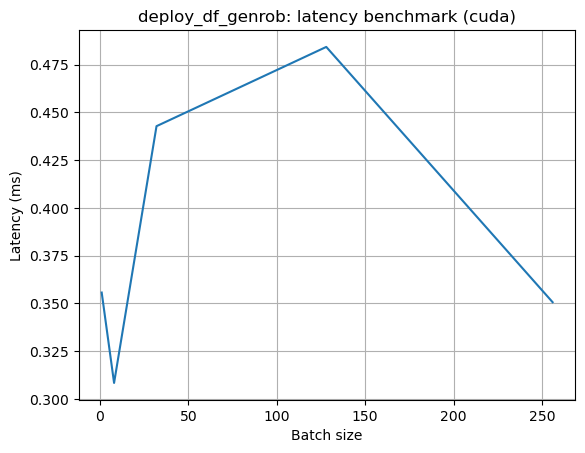

TorchScript export failed: export_torchscript() got an unexpected keyword argument 'in_dim'
ONNX export failed: export_onnx() got an unexpected keyword argument 'in_dim'


C:\Users\haith\AppData\Local\Temp\ipykernel_1372\1155363360.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sd = torch.load(ckpt, map_location=device)["model_state"]


,total_params,trainable_params,size_mb
0,102018,102018,0.389168


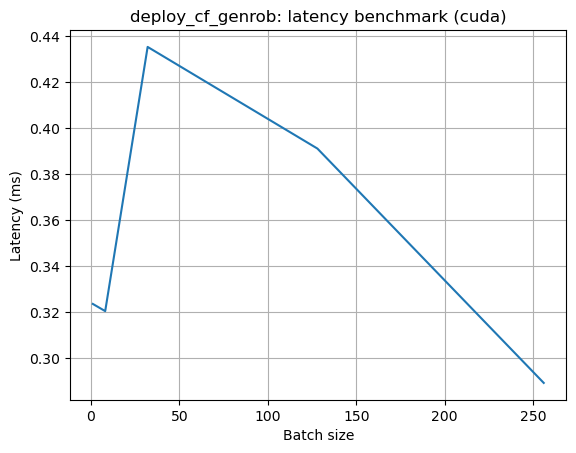

TorchScript export failed: export_torchscript() got an unexpected keyword argument 'in_dim'
ONNX export failed: export_onnx() got an unexpected keyword argument 'in_dim'


In [19]:
# Deployment indicators (params/size/latency/export)

def deploy_report(tag: str, model: torch.nn.Module, in_dim: int):
    ap = make_artifacts(tag)

    info = count_parameters(model)
    size = model_size_mb(model)

    lat = benchmark_model(
        model=model,
        device=device,
        in_dim=int(in_dim),
        batch_sizes=[1, 8, 32, 128, 256],
        cfg=BenchmarkConfig(warmup_iters=30, measure_iters=100),
    )
    df_lat = pd.DataFrame([{"batch": k, "latency_ms": v} for k, v in lat.items()]).sort_values("batch")

    (ap.results / "deploy_report.json").write_text(json.dumps({"params": info, "size_mb": size, "latency_ms": lat}, indent=2), encoding="utf-8")
    df_lat.to_csv(ap.results / "latency.csv", index=False)

    display(pd.DataFrame([{"total_params": info["total_params"], "trainable_params": info["trainable_params"], "size_mb": size}]))

    plt.figure()
    plt.plot(df_lat["batch"], df_lat["latency_ms"])
    plt.xlabel("Batch size")
    plt.ylabel("Latency (ms)")
    plt.title(f"{tag}: latency benchmark ({device.type})")
    plt.grid(True)
    fig = ap.figures / "latency.png"
    plt.savefig(fig, dpi=200, bbox_inches="tight")
    plt.show()

    # Export
    try:
        ts_path = export_torchscript(model.to(device).eval(), ap.results / "model.ts", in_dim=int(in_dim), device=device)
        print("TorchScript:", ts_path)
    except Exception as e:
        print("TorchScript export failed:", e)

    try:
        onnx_path = export_onnx(model.to(device).eval(), ap.results / "model.onnx", in_dim=int(in_dim), device=device)
        print("ONNX:", onnx_path)
    except Exception as e:
        print("ONNX export failed:", e)

    return ap

if RUN_DEPLOYMENT:
    if base_df_paths:
        m, _ = _load_ckpt(DFPolicy(in_dim=8), base_df_paths)
        _ = deploy_report("deploy_df_base", m, in_dim=8)
    if base_cf_paths:
        m, _ = _load_ckpt(CFPolicy(in_dim=8), base_cf_paths)
        _ = deploy_report("deploy_cf_base", m, in_dim=8)
    if genrob_df_paths:
        m, _ = _load_ckpt(GeneralizedDFPolicy(in_dim=11), genrob_df_paths)
        _ = deploy_report("deploy_df_genrob", m, in_dim=11)
    if genrob_cf_paths:
        m, _ = _load_ckpt(GeneralizedCFPolicy(in_dim=11), genrob_cf_paths)
        _ = deploy_report("deploy_cf_genrob", m, in_dim=11)
else:
    print("Skipping deployment.")
